In [31]:
from pulp import *
import pandas as pd
from typing import List, Tuple

In [32]:
alternatives = pd.read_csv("./data/UTA_milosz_alternatives.csv")
criteria = pd.read_csv("./data/UTA_milosz_criteria.csv")

In [33]:
alternatives

,name,experience,qualities,expectation
0,A,6,4,12.5
1,B,5,0,10.0
2,C,7,8,13.0
3,D,5,2,14.5
4,E,10,5,15.0
5,F,9,9,14.0
6,G,3,3,10.5
7,H,1,7,12.0
8,I,0,10,12.5
9,J,2,5,11.5


In [34]:
criteria

,criterion_name,criterion_type,alpha,beta,weight
0,experience,gain,0.0,10,8
1,qualities,gain,0.0,10,5
2,expectation,cost,NaN,0,7


In [35]:
criteria["weight"] /= sum(criteria["weight"])
criteria

,criterion_name,criterion_type,alpha,beta,weight
0,experience,gain,0.0,10,0.40
1,qualities,gain,0.0,10,0.25
2,expectation,cost,NaN,0,0.35


In [36]:

def fill_alpha_beta(alternatives: pd.DataFrame, criteria: pd.DataFrame) -> pd.DataFrame:
    """
    If any criteria don't have the values for the worst (alpha) or best (beta) performance,
    make them equal to the worst/best performances attained by the alternatives on this criterion
    """
    for idx, criterion in criteria.iterrows():
        if pd.isnull(criterion["alpha"]):
            if criterion["criterion_type"] == "gain":
                criterion["alpha"] = min(alternatives[criterion["criterion_name"]])
            if criterion["criterion_type"] == "cost":
                print(criterion["criterion_name"], max(alternatives[criterion["criterion_name"]]))
                criterion["alpha"] = max(alternatives[criterion["criterion_name"]])

        if pd.isnull(criterion["beta"]):
            if criterion["criterion_type"] == "gain":
                criterion["beta"] = max(alternatives[criterion["criterion_name"]])
            if criterion["criterion_type"] == "cost":
                criterion["beta"] = min(alternatives[criterion["criterion_name"]])
        criteria.loc[idx] = criterion

In [37]:
fill_alpha_beta(alternatives, criteria)
criteria

expectation 15.0


,criterion_name,criterion_type,alpha,beta,weight
0,experience,gain,0.0,10,0.40
1,qualities,gain,0.0,10,0.25
2,expectation,cost,15.0,0,0.35



Expected preferences from project1:
- Path of Exile > Last Epoch
- Divinity Original Sin 2 > Gears Tactics
- Portal 2 > Superliminal
- Slay the Spire > Rogue Legacy 2

Additional comparisions:
- Terraria > Elden Ring
- Slay the Spire > Nebuchadnezzar
- Elden Ring > Nebuchadnezzar
- Nebuchadnezzar > Terraria (to introduce inconsistency)


In [172]:
def ordinal_regression_model(alternatives: pd.DataFrame, criteria: pd.DataFrame, comparisions: List[Tuple[str, str, str]], num_breakpoints: int = 0) -> LpProblem:
    alternative_names = alternatives.iloc[:, 0].tolist()
    criteria_names = criteria.iloc[:, 0].tolist()
    model = LpProblem(name="Ordinal Regression", sense=LpMinimize)

    # definig the objective function - sum of under- and over-estimation errors
    over_error_variables = LpVariable.dicts("over", alternative_names, lowBound=0)
    under_error_variables = LpVariable.dicts("under", alternative_names, lowBound=0)
    model += lpSum([x for x in list(under_error_variables.values())+list(over_error_variables.values())])

    # dictionary containing variables corresponding to values of marginal preference functions
    # at all characteristic points for every criterion
    characteristic_p_dict = dict([(name, [None] * (num_breakpoints+2)) for name in criteria_names])

    # all worst performances must be 0
    # the sum of best performances must be equal 1
    beta_variables = []
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        criterion_type = criterion["criterion_type"]
        u_a = LpVariable(name=f"{criterion_name}_u_a", lowBound=0, upBound=0)
        # we assume that weights are normalised already
        u_b = LpVariable(name=f"{criterion_name}_u_b", lowBound=criterion["weight"], upBound=criterion["weight"])
        beta_variables.append(u_b)
        model += (u_a == 0, f"u_a_{criterion_name}")
        if criterion_type == "gain":
            characteristic_p_dict[criterion_name][0] = u_a
            characteristic_p_dict[criterion_name][-1] = u_b
        if criterion_type == "cost":
            characteristic_p_dict[criterion_name][0] = u_b
            characteristic_p_dict[criterion_name][-1] = u_a


    model += LpConstraint(lpSum(beta_variables), sense=LpConstraintEQ, name="Sum of u_i(\Beta) = 1", rhs=1)

    # add monotonicity constraints for breakpoints
    for _, criterion in criteria.iterrows():
        criterion_type = criterion["criterion_type"]
        criterion_name = criterion["criterion_name"]

        # the "breakpoint" variables indicate the value of marginal value function at the breakpoint
        if criterion_type == "cost":
            previous_breakpoint = criterion["weight"]
            for i in range(num_breakpoints):
                breakpoint = LpVariable(name=f"{criterion_name}_breakpoint_{i+1}", lowBound=0)
                # +1 in index, because 0th is for the first characteristic point
                characteristic_p_dict[criterion_name][i+1] = breakpoint
                # for cost type, the marginal value function must be NON-INcreasing
                # as such, the value at the next break point must be <= the previous
                model += LpConstraint(previous_breakpoint-breakpoint, sense=LpConstraintGE, name=f"{criterion_name}_monotonicity_{i+1}")
                previous_breakpoint = breakpoint

        if criterion_type == "gain":
            previous_breakpoint = 0
            for i in range(num_breakpoints):
                breakpoint = LpVariable(name=f"{criterion_name}_breakpoint_{i+1}", lowBound=0)
                characteristic_p_dict[criterion_name][i+1] = breakpoint
                # for gain type, the function should be NON-DEcreasing
                model += LpConstraint(breakpoint-previous_breakpoint, sense=LpConstraintGE, name=f"{criterion_name}_monotonicity_{i+1}")
                previous_breakpoint = breakpoint
    # pairwise comparisions
    sense_dict = dict([(">", LpConstraintGE), ("=", LpConstraintEQ), ("<", LpConstraintLE)])
    coeffs = [1, -1, 1]
    # creating a dictionary of comprehensive value variables to avoid duplicates
    # for every performance of every alternative, its performance relative to some breakpoint must be calculated
    # here, the value at the breakpoint for the largest value of performance that is NOT GREATER than the alternative's is used as reference
    U_variables = dict([(name, lpSum([])) for name in alternative_names])
    # fraction of the range of g(a) that is spanned between two breakpoints
    bucket_width = 1/(num_breakpoints+1)
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        criterion_type = criterion["criterion_type"]
        alpha = criterion["alpha"]
        beta = criterion["beta"]
        if criterion_type == "gain":
            interval = beta - alpha
            smallest_val = alpha
        if criterion_type == "cost":
            interval = alpha - beta
            smallest_val = beta
        for _, alternative in alternatives.iterrows():
            alternative_name = alternative[0]
            performance = alternative[criterion_name]
            relative_performance = (performance - smallest_val)/interval
            characteristic_idx = int(relative_performance/bucket_width)
            absolute_perf_in_bucket = performance - smallest_val - bucket_width * interval * characteristic_idx
            # if the alternative's performance on the criterion lines up with a characterisitc point
            if absolute_perf_in_bucket == 0:
                U_variables[alternative_name] += characteristic_p_dict[criterion_name][characteristic_idx]
                continue
            # otherwise, the value should be equal to the p
            relative_perf_in_bucket = absolute_perf_in_bucket / (bucket_width * interval)
            characteristic_p_var = characteristic_p_dict[criterion_name][characteristic_idx]
            next_p_var = characteristic_p_dict[criterion_name][characteristic_idx+1]
            U_variables[alternative_name] += characteristic_p_var + relative_perf_in_bucket * (next_p_var - characteristic_p_var)
    # difference in additive value functions judged sufficient to represent strict preference
    strict_diff = 0.001
    for a, b, relation in comparisions:
        a_over = over_error_variables[a]
        a_under = under_error_variables[a]
        b_over = over_error_variables[b]
        b_under = under_error_variables[b]
        U_a = U_variables[a]
        U_b = U_variables[b]
        print(b, U_b)
        sense = sense_dict[relation]
        left = lpSum([c*x for c, x in zip(coeffs, [U_a, a_over, a_under])])
        right = lpSum([[c*x for c, x in zip(coeffs, [U_b, b_over, b_under])]])
        # transformed to compare to a constant, because that's what PuLP wants
        model += LpConstraint(left-right, sense=sense, name=f"{a}{relation}{b}", rhs=strict_diff)

    return model


In [199]:
model = ordinal_regression_model(alternatives, criteria, [("E", "B", ">"), ("B", "I", ">")], 2)
model

B expectation_breakpoint_2 + 0.4999999999999999*experience_breakpoint_1 + 0.5000000000000001*experience_breakpoint_2 + qualities_u_a
I 0.5*expectation_breakpoint_2 + 0.5*expectation_u_a + experience_u_a + qualities_u_b


c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Ordinal_Regression:
MINIMIZE
1*over_A + 1*over_B + 1*over_C + 1*over_D + 1*over_E + 1*over_F + 1*over_G + 1*over_H + 1*over_I + 1*over_J + 1*under_A + 1*under_B + 1*under_C + 1*under_D + 1*under_E + 1*under_F + 1*under_G + 1*under_H + 1*under_I + 1*under_J + 0
SUBJECT TO
u_a_experience: experience_u_a = 0

u_a_qualities: qualities_u_a = 0

u_a_expectation: expectation_u_a = 0

Sum_of_u_i(\Beta)_=_1: expectation_u_b + experience_u_b + qualities_u_b = 1

experience_monotonicity_1: experience_breakpoint_1 >= 0

experience_monotonicity_2: - experience_breakpoint_1 + experience_breakpoint_2
 >= 0

qualities_monotonicity_1: qualities_breakpoint_1 >= 0

qualities_monotonicity_2: - qualities_breakpoint_1 + qualities_breakpoint_2
 >= 0

expectation_monotonicity_1: - expectation_breakpoint_1 >= -0.35

expectation_monotonicity_2: expectation_breakpoint_1
 - expectation_breakpoint_2 >= 0

E>B: - expectation_breakpoint_2 + expectation_u_a
 - 0.5 experience_breakpoint_1 - 0.5 experience_breakpoint_2

In [200]:
status = model.solve()
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"Objective function value: {model.objective.value()}")

status: 1, Optimal
Objective function value: 0.0


In [201]:
for var in model.variables():
    print(var.name, var.value())

expectation_breakpoint_1 0.35
expectation_breakpoint_2 0.0
expectation_u_a 0.0
expectation_u_b 0.35
experience_breakpoint_1 0.251
experience_breakpoint_2 0.251
experience_u_a 0.0
experience_u_b 0.4
over_A 0.0
over_B 0.0
over_C 0.0
over_D 0.0
over_E 0.0
over_F 0.0
over_G 0.0
over_H 0.0
over_I 0.0
over_J 0.0
qualities_breakpoint_1 0.0
qualities_breakpoint_2 0.0
qualities_u_a 0.0
qualities_u_b 0.25
under_A 0.0
under_B 0.0
under_C 0.0
under_D 0.0
under_E 0.0
under_F 0.0
under_G 0.0
under_H 0.0
under_I 0.0
under_J 0.0


In [202]:
import matplotlib.pyplot as plt
import re

In [203]:
type(model.variables())

list

In [269]:
# WARNING: changing naming convenctions in the model breaks the function!!!
def draw_marginal_value_functions(model: LpProblem, criteria: pd.DataFrame) -> None:
    regular_expressions = []
    criteria_names = criteria.iloc[:, 0].tolist()
    criteria_var_dict = dict([(name, []) for name in criteria_names])
    for name in criteria_names:
        regex = f"({name}_breakpoint_\d+)|({name}_u_a)|({name}_u_b)"
        regex = re.compile(regex)
        regular_expressions.append(regex)
    for var in model.variables():
        criterion_name = None
        for regex in regular_expressions:
            if not re.search(regex, var.name):
                continue
            # get everything before the last 2 underscores
            criterion_name = "_".join(var.name.split('_')[:-2])
            criteria_var_dict[criterion_name].append(var)
            break
    for _, criterion in criteria.iterrows():
        criterion_name = criterion["criterion_name"]
        criterion_type = criterion["criterion_type"]
        alpha = criterion["alpha"]
        beta = criterion["beta"]
        vars = criteria_var_dict[criterion_name]
        num_breakpoints = len(vars)-2
        interval = None
        if criterion_type == "gain":
            interval = beta - alpha
            vars.sort(key = lambda x:  x.name[-4:])
            # shift list to the left by 1
            vars.append(vars.pop(0))
            # swap u(b) with u(a)
            vars[0], vars[-1] = vars[-1], vars[0]
        if criterion_type == "cost":
            interval = alpha - beta
            vars.sort(key = lambda x: x.name[-4:])
            # shift list to the left by 1
            vars.append(vars.pop(0))
        gs = []
        vals = []
        for idx, var in enumerate(vars):
            g = min(alpha, beta) + idx * (interval/(num_breakpoints+1))
            gs.append(g)
            vals.append(var.value())
        plt.plot(gs, vals, "-o")
        plt.xticks(gs)
        plt.ylim(-0.001, max(criteria["weight"]))
        plt.xlabel(f"Performance on {criterion_name}")
        plt.ylabel(f"Value function")
        plt.show()

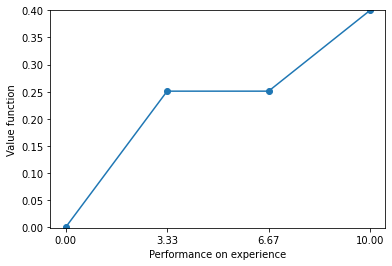

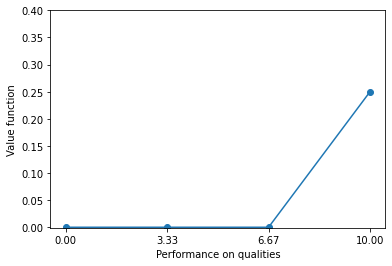

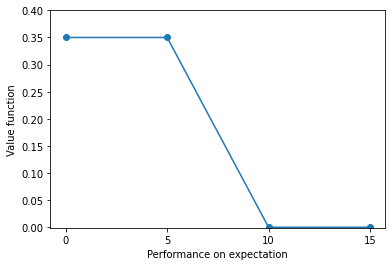

In [270]:
draw_marginal_value_functions(model, criteria)